# 🧱 Environment Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import warnings
from IPython.display import display, Markdown
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
import os
import re
import ast
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sentence_transformers import SentenceTransformer
import torch
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import cosine_similarity
import random # For cluster sampling

c:\Users\durvi\OneDrive\Documents\SEM5\rs\Exps\miniproj\FitRec-Workout-Recommender-Mini-Proj\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ex_df_orig = pd.read_csv('..\datasets\programs_detailed_boostcamp_kaggle.csv')
prog_df = pd.read_csv('..\datasets\program_summary.csv')

# --- Initial Data Cleaning (prog_df for embedding approach) ---
if 'Unnamed: 0' in prog_df.columns:
    prog_df = prog_df.drop(columns=['Unnamed: 0'])
if 'Unnamed: 0' in ex_df_orig.columns:
    ex_df_orig = ex_df_orig.drop(columns=['Unnamed: 0'])

print('Original Exercises shape:', ex_df_orig.shape)
print('Programs Summary shape:', prog_df.shape)
print("\nOriginal Exercise Columns:", ex_df_orig.columns.tolist())
print("\nProgram Summary Columns:", prog_df.columns.tolist())

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\durvi\AppData\Local\Temp\ipykernel_193888\3208000834.py:1: SyntaxWarning: invalid escape sequence '\d'
  ex_df_orig = pd.read_csv('..\datasets\programs_detailed_boostcamp_kaggle.csv')
C:\Users\durvi\AppData\Local\Temp\ipykernel_193888\3208000834.py:2: SyntaxWarning: invalid escape sequence '\d'
  prog_df = pd.read_csv('..\datasets\program_summary.csv')


Original Exercises shape: (605033, 16)
Programs Summary shape: (2598, 10)

Original Exercise Columns: ['title', 'description', 'level', 'goal', 'equipment', 'program_length', 'time_per_workout', 'week', 'day', 'number_of_exercises', 'exercise_name', 'sets', 'reps', 'intensity', 'created', 'last_edit']

Program Summary Columns: ['title', 'description', 'level', 'goal', 'equipment', 'program_length', 'time_per_workout', 'total_exercises', 'created', 'last_edit']


# 📊 Exploratory Data Analysis (EDA) & Preprocessing
We’ll explore distributions, missing values, and prepare key fields for modeling.

We’re building a personalized program recommender using:

1. Metadata features: goal, level, equipment, program_length, etc.

2. Text fields: title, description, exercise_name

3. Personalization layer: modeled via user history, i.e., users who interacted with similar programs

# 🧼 Cleaning Metadata and Text

In [3]:
prog_df['program_length_orig'] = prog_df['program_length']
prog_df['time_per_workout_orig'] = prog_df['time_per_workout']
prog_df['program_length'].fillna(prog_df['program_length'].median(), inplace=True)
prog_df['time_per_workout'].fillna(prog_df['time_per_workout'].median(), inplace=True)
scaler = MinMaxScaler()
prog_df[['program_length', 'time_per_workout']] = scaler.fit_transform(prog_df[['program_length', 'time_per_workout']])
label_encoders = {}
for col in ['goal', 'level', 'equipment']:
    prog_df[col] = prog_df[col].fillna('unknown').str.lower().str.strip()
    le = LabelEncoder()
    prog_df[col + '_enc'] = le.fit_transform(prog_df[col])
    label_encoders[col] = le
def clean_text(text):
    if pd.isna(text): return ''
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.strip()
prog_df['title_cleaned'] = prog_df['title'].astype(str).apply(clean_text)
prog_df['description_cleaned'] = prog_df['description'].astype(str).apply(clean_text)
ex_df_orig['exercise_name'] = ex_df_orig['exercise_name'].astype(str) # Clean original ex_df as well
top_exercises = (ex_df_orig.groupby('title')['exercise_name']
                 .apply(lambda x: ' '.join(x.dropna().astype(str).str.lower().str.replace(r'[^a-zA-Z0-9\s]', '', regex=True).unique()[:5])))
prog_df = prog_df.merge(top_exercises.rename('common_exercises'), on='title', how='left')
prog_df['common_exercises'] = prog_df['common_exercises'].fillna('')
prog_df['text_input'] = (
    prog_df['title_cleaned'] + ' ' +
    prog_df['description_cleaned'] + ' ' +
    prog_df['common_exercises']
)
print("\n--- Sample Processed Summary Data ---")
display(prog_df[['title', 'goal', 'level', 'equipment', 'program_length_orig', 'time_per_workout_orig', 'text_input']].head(3))

C:\Users\durvi\AppData\Local\Temp\ipykernel_193888\1080143011.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  prog_df['program_length'].fillna(prog_df['program_length'].median(), inplace=True)
C:\Users\durvi\AppData\Local\Temp\ipykernel_193888\1080143011.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value


--- Sample Processed Summary Data ---


,title,goal,level,equipment,program_length_orig,time_per_workout_orig,text_input
0,(MASS MONSTER) High Intensity 4 Day Upper Lowe...,"['muscle & sculpting', 'bodyweight fitness']",['intermediate'],full gym,12.0,90.0,mass monster high intensity 4 day upper lower ...
1,(NOT MY PROGRAM)SHJ Jotaro,['bodybuilding'],"['advanced', 'intermediate']",full gym,8.0,60.0,not my programshj jotaro build strength and si...
2,1 PowerLift Per Day Powerbuilding 5 Day Bro Split,"['athletics', 'powerlifting', 'powerbuilding']","['beginner', 'novice', 'intermediate']",full gym,6.0,90.0,1 powerlift per day powerbuilding 5 day bro sp...


# 🧠 Feature Engineering (Text Embeddings + Metadata Encoding)
* Encode goal, level, and equipment using LabelEncoder

* Generate dense text embeddings using a SentenceTransformer model (e.g. all-MiniLM-L6-v2)

* Concatenate metadata and text embeddings into a final feature vector per program

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
try:
    model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
except Exception as e:
    print(f"Error loading SentenceTransformer model: {e}")
    raise e
batch_texts = prog_df['text_input'].tolist()
batch_size = 64
text_embeddings = []
num_batches = (len(batch_texts) + batch_size - 1) // batch_size
print(f"Generating embeddings for {len(batch_texts)} programs in {num_batches} batches...")
for i in range(0, len(batch_texts), batch_size):
    batch = batch_texts[i:i + batch_size]
    emb = model.encode(batch, show_progress_bar=False)
    text_embeddings.append(emb)
    print(f"Processed batch {i//batch_size + 1}/{num_batches}")
text_embeddings = np.vstack(text_embeddings)
embedding_cols = [f'emb_{i}' for i in range(text_embeddings.shape[1])]
embedding_df = pd.DataFrame(text_embeddings, columns=embedding_cols, index=prog_df.index)
prog_df = pd.concat([prog_df, embedding_df], axis=1)
metadata_cols = ['goal_enc', 'level_enc', 'equipment_enc', 'program_length', 'time_per_workout']
all_features_cols = metadata_cols + embedding_cols
features_clean = prog_df[all_features_cols].fillna(0).values
print("\nFeature matrix shape (Embeddings + Metadata):", features_clean.shape)

Using device: cpu


c:\Users\durvi\OneDrive\Documents\SEM5\rs\Exps\miniproj\FitRec-Workout-Recommender-Mini-Proj\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\durvi\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this 

Generating embeddings for 2598 programs in 41 batches...
Processed batch 1/41
Processed batch 2/41
Processed batch 3/41
Processed batch 4/41
Processed batch 5/41
Processed batch 6/41
Processed batch 7/41
Processed batch 8/41
Processed batch 9/41
Processed batch 10/41
Processed batch 11/41
Processed batch 12/41
Processed batch 13/41
Processed batch 14/41
Processed batch 15/41
Processed batch 16/41
Processed batch 17/41
Processed batch 18/41
Processed batch 19/41
Processed batch 20/41
Processed batch 21/41
Processed batch 22/41
Processed batch 23/41
Processed batch 24/41
Processed batch 25/41
Processed batch 26/41
Processed batch 27/41
Processed batch 28/41
Processed batch 29/41
Processed batch 30/41
Processed batch 31/41
Processed batch 32/41
Processed batch 33/41
Processed batch 34/41
Processed batch 35/41
Processed batch 36/41
Processed batch 37/41
Processed batch 38/41
Processed batch 39/41
Processed batch 40/41
Processed batch 41/41

Feature matrix shape (Embeddings + Metadata): (25

# 👥 KMeans Clustering for User Interest Simulation
We’ll:

1. Fit KMeans on the 389-dimensional feature matrix

2. Assign each program a cluster_id

3. Simulate users by assuming each cluster represents a set of preferences


Running KMeans with 25 clusters (Embeddings + Metadata)...
KMeans clustering (Embeddings + Metadata) complete.
Running PCA for visualization...
PCA complete.


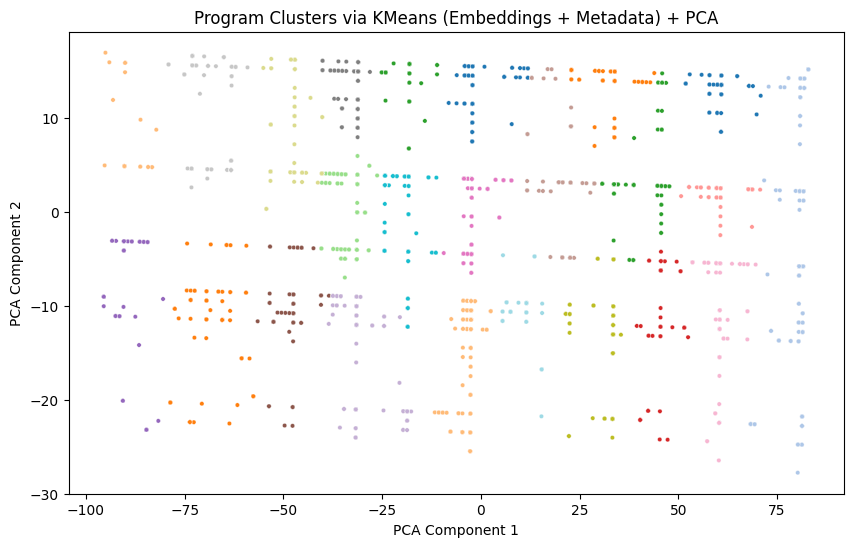

In [5]:
NUM_CLUSTERS_EMBED = 25
print(f"\nRunning KMeans with {NUM_CLUSTERS_EMBED} clusters (Embeddings + Metadata)...")
kmeans_embed = KMeans(n_clusters=NUM_CLUSTERS_EMBED, random_state=42, n_init='auto')
prog_df['cluster_id_embed'] = kmeans_embed.fit_predict(features_clean)
print("KMeans clustering (Embeddings + Metadata) complete.")
print("Running PCA for visualization...")
pca_embed = PCA(n_components=2)
proj_embed = pca_embed.fit_transform(features_clean)
prog_df['pca1_embed'], prog_df['pca2_embed'] = proj_embed[:, 0], proj_embed[:, 1]
print("PCA complete.")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=prog_df, x='pca1_embed', y='pca2_embed', hue='cluster_id_embed', palette='tab20', legend=False, s=10)
plt.title('Program Clusters via KMeans (Embeddings + Metadata) + PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# 🔁 Step 4: Recommendation Engine Setup (Based on Embeddings + Metadata)

In [6]:
print("\nCalculating similarity matrix (Embeddings + Metadata)...")
similarity_matrix_embed = cosine_similarity(features_clean)
print("Similarity matrix calculated.")


Calculating similarity matrix (Embeddings + Metadata)...
Similarity matrix calculated.


# 🎯 Step 5: Interactive Recommendations (Based on Metadata Clustering - User Input Report Style)

In [7]:
# --- Define Functions for Metadata-Only Clustering Recommendation ---
def clean_and_parse(s):
    if not isinstance(s, str):
        return np.nan
    s = s.strip()
    try:
        val = ast.literal_eval(s)
        if isinstance(val, list) and len(val) > 0:
            return val[0]
        return val
    except (ValueError, SyntaxError):
        return s

def create_metadata_clustering_model(df_meta):
    print("Building the metadata-only clustering model...")
    features = df_meta[['goal', 'level', 'equipment']].copy()
    features.fillna('unknown', inplace=True)
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoded_features = ohe.fit_transform(features)
    num_clusters = min(len(df_meta['goal'].unique()) * len(df_meta['level'].unique()) * 2, len(df_meta))
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    kmeans.fit(encoded_features)
    df_meta['cluster_metadata'] = kmeans.labels_
    print("Metadata-only clustering model built successfully.")
    return kmeans, ohe, df_meta

def recommend_by_metadata_cluster(user_goal, user_level, user_equipment, kmeans_model, ohe_encoder, df_meta, num_recommendations=5):
    user_input_df = pd.DataFrame([[user_goal.lower(), user_level.lower(), user_equipment.lower()]],
                                 columns=['goal', 'level', 'equipment'])
    user_encoded = ohe_encoder.transform(user_input_df)
    user_cluster = kmeans_model.predict(user_encoded)[0]
    cluster_workouts = df_meta[df_meta['cluster_metadata'] == user_cluster]
    if cluster_workouts.empty:
        print("No workouts found in the matching metadata cluster.")
        return pd.DataFrame()
    if len(cluster_workouts) > num_recommendations:
        return cluster_workouts.sample(n=num_recommendations, random_state=random.seed())
    else:
        return cluster_workouts

# --- Prepare Data for Metadata Clustering ---
df_meta_cluster = ex_df_orig.drop_duplicates(subset=['title'], keep='first').copy()
for col in ['goal', 'level', 'equipment']:
    df_meta_cluster[col] = df_meta_cluster[col].apply(clean_and_parse)
df_meta_cluster.dropna(subset=['goal', 'level', 'equipment', 'description', 'title'], inplace=True)
if df_meta_cluster.empty:
    raise ValueError("DataFrame for metadata clustering is empty after cleaning.")
else:
    df_meta_cluster['goal'] = df_meta_cluster['goal'].astype(str).str.lower()
    df_meta_cluster['level'] = df_meta_cluster['level'].astype(str).str.lower()
    df_meta_cluster['equipment'] = df_meta_cluster['equipment'].astype(str).str.lower()

# --- Add original length/time to df_meta_cluster for filtering ---
# Need to merge with prog_df to get these columns
df_meta_cluster = pd.merge(
    df_meta_cluster,
    prog_df[['title', 'program_length_orig', 'time_per_workout_orig']],
    on='title',
    how='left'
)
# Handle potential NaNs introduced by the merge if titles didn't match perfectly
df_meta_cluster['program_length_orig'].fillna(df_meta_cluster['program_length_orig'].median(), inplace=True)
df_meta_cluster['time_per_workout_orig'].fillna(df_meta_cluster['time_per_workout_orig'].median(), inplace=True)


# --- Create Metadata Clustering Model ---
kmeans_meta_model, ohe_meta_encoder, processed_meta_df = create_metadata_clustering_model(df_meta_cluster)


# --- Get User Input for Metadata Clustering Recommendation ---
print("\n--- Get User Preferences for Metadata Cluster Recommendations ---")
unique_goals_meta = set(g for g in processed_meta_df['goal'].unique() if g != 'unknown')
sorted_goals = sorted(list(unique_goals_meta))
unique_levels_meta = set(l for l in processed_meta_df['level'].unique() if l != 'unknown')
sorted_levels = sorted(list(unique_levels_meta))
unique_equipment_meta = set(e for e in processed_meta_df['equipment'].unique() if e != 'unknown')
sorted_equipment = sorted(list(unique_equipment_meta))

print("\nAvailable Goals:")
for i, goal in enumerate(sorted_goals): print(f"{i+1}. {goal.capitalize()}")
while True:
    try:
        goal_choice_idx_meta = int(input(f"Enter the number for your fitness goal (1-{len(sorted_goals)}): "))
        if 1 <= goal_choice_idx_meta <= len(sorted_goals):
            user_goal_meta = sorted_goals[goal_choice_idx_meta-1]
            break
        else: print("Invalid number.")
    except ValueError: print("Invalid input. Please enter a number.")

print("\nAvailable Levels:")
for i, level in enumerate(sorted_levels): print(f"{i+1}. {level.capitalize()}")
while True:
    try:
        level_choice_idx_meta = int(input(f"Enter the number for your fitness level (1-{len(sorted_levels)}): "))
        if 1 <= level_choice_idx_meta <= len(sorted_levels):
            user_level_meta = sorted_levels[level_choice_idx_meta-1]
            break
        else: print("Invalid number.")
    except ValueError: print("Invalid input. Please enter a number.")

print("\nAvailable Equipment:")
for i, equip in enumerate(sorted_equipment): print(f"{i+1}. {equip.capitalize()}")
while True:
    try:
        equip_choice_idx_meta = int(input(f"Enter the number for your available equipment (1-{len(sorted_equipment)}): "))
        if 1 <= equip_choice_idx_meta <= len(sorted_equipment):
            user_equipment_meta = sorted_equipment[equip_choice_idx_meta-1]
            break
        else: print("Invalid number.")
    except ValueError: print("Invalid input. Please enter a number.")

# --- Get NEW User Input for Length and Time ---
max_len_input_meta = input("Enter maximum program length in weeks (leave blank for any): ")
user_max_length_meta = float(max_len_input_meta) if max_len_input_meta.strip() else None

max_time_input_meta = input("Enter maximum time per workout in minutes (leave blank for any): ")
user_max_time_meta = float(max_time_input_meta) if max_time_input_meta.strip() else None

# --- Generate Recommendations using Metadata Cluster ---
print(f"\nSearching for workouts based on these preferences (Metadata Cluster):")
print(f"  Goal: {user_goal_meta}")
print(f"  Level: {user_level_meta}")
print(f"  Equipment: {user_equipment_meta}")
if user_max_length_meta is not None: print(f"  Max Length: {user_max_length_meta} weeks")
if user_max_time_meta is not None: print(f"  Max Time/Workout: {user_max_time_meta} minutes")
print("")

# --- Filter BEFORE recommending from cluster ---
filtered_meta_df = processed_meta_df.copy()
if user_max_length_meta is not None:
    filtered_meta_df = filtered_meta_df[filtered_meta_df['program_length_orig'] <= user_max_length_meta]
if user_max_time_meta is not None:
    filtered_meta_df = filtered_meta_df[filtered_meta_df['time_per_workout_orig'] <= user_max_time_meta]

recommendations_meta = recommend_by_metadata_cluster(
    user_goal_meta, user_level_meta, user_equipment_meta,
    kmeans_meta_model, ohe_meta_encoder, filtered_meta_df # Use filtered df here
)

# --- Display Detailed Recommendations ---
if not recommendations_meta.empty:
    # No need to merge again, length/time are already in recommendations_meta
    print("--- Recommended Workouts (Metadata Cluster Report) ---")
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.width', 1000)

    for index, row in recommendations_meta.iterrows():
        display(Markdown(f"### {row['title']}"))
        display(Markdown(f"**Goal:** {row['goal'].title()} | **Level:** {row['level'].title()} | **Equipment:** {row['equipment'].title()}"))

        length_str = f"{row['program_length_orig']} weeks" if pd.notna(row['program_length_orig']) else "N/A"
        time_str = f"{row['time_per_workout_orig']} minutes" if pd.notna(row['time_per_workout_orig']) else "N/A"
        display(Markdown(f"**Program Length:** {length_str} | **Time per Workout:** {time_str}"))
        display(Markdown(f"**Description:** {row['description']}"))

        program_exercises = ex_df_orig[ex_df_orig['title'] == row['title']].sort_values(by=['week', 'day'])
        if not program_exercises.empty:
            display(Markdown("**Exercises in this plan:**"))
            exercise_limit = 20
            displayed_exercises = 0
            for ex_index, ex_row in program_exercises.iterrows():
                 if displayed_exercises >= exercise_limit:
                     display(Markdown("  *... (additional exercises omitted for brevity)*"))
                     break
                 display(Markdown(f"  - *Week {int(ex_row['week'])}, Day {int(ex_row['day'])}:* {ex_row['exercise_name']} ({ex_row.get('sets', '-')} sets, {ex_row.get('reps', '-')} reps, Intensity: {ex_row.get('intensity', '-')})"))
                 displayed_exercises += 1
        else:
            display(Markdown("*No detailed exercises found for this program.*"))
        display(Markdown("---"))

    pd.reset_option('display.max_colwidth')
    pd.reset_option('display.width')
else:
    print("No recommendations found for the given criteria using metadata clustering.")

Building the metadata-only clustering model...
Metadata-only clustering model built successfully.

--- Get User Preferences for Metadata Cluster Recommendations ---

Available Goals:
1. []
2. Athletics
3. Bodybuilding
4. Bodyweight fitness
5. Muscle & sculpting
6. Olympic weightlifting
7. Powerbuilding
8. Powerlifting


C:\Users\durvi\AppData\Local\Temp\ipykernel_193888\3907714884.py:62: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_meta_cluster['program_length_orig'].fillna(df_meta_cluster['program_length_orig'].median(), inplace=True)
C:\Users\durvi\AppData\Local\Temp\ipykernel_193888\3907714884.py:63: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object o


Available Levels:
1. []
2. Advanced
3. Beginner
4. Intermediate
5. Novice

Available Equipment:
1. At home
2. Dumbbell only
3. Full gym
4. Garage gym

Searching for workouts based on these preferences (Metadata Cluster):
  Goal: bodybuilding
  Level: advanced
  Equipment: full gym
  Max Length: 10.0 weeks
  Max Time/Workout: 60.0 minutes

--- Recommended Workouts (Metadata Cluster Report) ---


### Shoulder Rehab

**Goal:** Bodybuilding | **Level:** Advanced | **Equipment:** Full Gym

**Program Length:** 3.0 weeks | **Time per Workout:** 30.0 minutes

**Description:** Do you have shoulder pain during Benching or other exercises?
Did you tear your shoulder?
Do everyday tasks hurt your shoulder or rotator cuffs?
Do you want better shoulder health?
If taken seriously this program should help, you may need to do it multiple times to see the best results.
You should be running a general strength, calisthenics, or hypertrophy program along side this because you need the surrounding muscles of the shoulder to be strong too.

**Exercises in this plan:**

  - *Week 1, Day 1:* Internal Rotation (2.0 sets, 20.0 reps, Intensity: 8.0)

  - *Week 1, Day 1:* Face Pull (Rotator Cuff) (2.0 sets, 20.0 reps, Intensity: 8.0)

  - *Week 1, Day 1:* Cable Y Raise (Rehab) (2.0 sets, 5.0 reps, Intensity: 8.0)

  - *Week 1, Day 2:* Internal Rotation (2.0 sets, 8.0 reps, Intensity: 8.0)

  - *Week 1, Day 2:* Face Pull (Rotator Cuff) (2.0 sets, 10.0 reps, Intensity: 8.0)

  - *Week 1, Day 2:* Cable Y Raise (Rehab) (2.0 sets, 5.0 reps, Intensity: 6.0)

  - *Week 1, Day 3:* Internal Rotation (2.0 sets, 8.0 reps, Intensity: 5.0)

  - *Week 1, Day 3:* Face Pull (Rotator Cuff) (2.0 sets, 20.0 reps, Intensity: 6.0)

  - *Week 1, Day 3:* Cable Y Raise (Rehab) (2.0 sets, 5.0 reps, Intensity: 5.0)

  - *Week 2, Day 1:* Internal Rotation (2.0 sets, 5.0 reps, Intensity: 6.0)

  - *Week 2, Day 1:* Face Pull (Rotator Cuff) (2.0 sets, 20.0 reps, Intensity: 5.0)

  - *Week 2, Day 1:* Cable Y Raise (Rehab) (2.0 sets, -60.0 reps, Intensity: 6.0)

  - *Week 2, Day 2:* Internal Rotation (2.0 sets, -60.0 reps, Intensity: 5.0)

  - *Week 2, Day 2:* Face Pull (Rotator Cuff) (2.0 sets, 8.0 reps, Intensity: 6.0)

  - *Week 2, Day 2:* Cable Y Raise (Rehab) (2.0 sets, 10.0 reps, Intensity: 5.0)

  - *Week 2, Day 3:* Internal Rotation (2.0 sets, 12.0 reps, Intensity: 6.0)

  - *Week 2, Day 3:* Face Pull (Rotator Cuff) (2.0 sets, 20.0 reps, Intensity: 5.0)

  - *Week 2, Day 3:* Cable Y Raise (Rehab) (2.0 sets, 20.0 reps, Intensity: 6.0)

  - *Week 3, Day 1:* Internal Rotation (2.0 sets, 20.0 reps, Intensity: 5.0)

  - *Week 3, Day 1:* Face Pull (Rotator Cuff) (2.0 sets, 20.0 reps, Intensity: 6.0)

  *... (additional exercises omitted for brevity)*

---

### WILL DODDS METHOD 4 DAYS

**Goal:** Bodybuilding | **Level:** Advanced | **Equipment:** Full Gym

**Program Length:** 4.0 weeks | **Time per Workout:** 50.0 minutes

**Description:** A simple strength program. It should be used with at least 2 active recovery days of cardio, or more hypertrophy volume for your weakpoints. 

Can also be run alone training 4x per week. 

Was designed as late stage PCL/ACL rehab

**Exercises in this plan:**

  - *Week 1, Day 1:* Bench Press (Barbell) (4.0 sets, 10.0 reps, Intensity: 9.0)

  - *Week 1, Day 1:* Meadow Row (4.0 sets, 12.0 reps, Intensity: 8.0)

  - *Week 1, Day 1:* Seated Overhead Press (Dumbbell) (4.0 sets, 8.0 reps, Intensity: 8.0)

  - *Week 1, Day 1:* Overhead Tricep Extension (Cable) (1.0 sets, 8.0 reps, Intensity: 8.0)

  - *Week 1, Day 2:* Squat (Barbell) (4.0 sets, 10.0 reps, Intensity: 9.0)

  - *Week 1, Day 2:* Leg Extension (1.0 sets, 12.0 reps, Intensity: 8.0)

  - *Week 1, Day 2:* Leg Press (3.0 sets, 10.0 reps, Intensity: 9.0)

  - *Week 1, Day 2:* Seated Calf Raise (1.0 sets, 12.0 reps, Intensity: 8.0)

  - *Week 1, Day 3:* Bench Press (Barbell) (4.0 sets, 12.0 reps, Intensity: 8.0)

  - *Week 1, Day 3:* Military Press (Barbell) (3.0 sets, 10.0 reps, Intensity: 9.0)

  - *Week 1, Day 3:* Bent Over Row (Dumbbell) (4.0 sets, 8.0 reps, Intensity: 9.0)

  - *Week 1, Day 3:* Lat Pulldown (4.0 sets, 10.0 reps, Intensity: 9.0)

  - *Week 1, Day 3:* Spider Curl (1.0 sets, -120.0 reps, Intensity: 8.0)

  - *Week 1, Day 4:* Leg Extension (1.0 sets, 8.0 reps, Intensity: 8.0)

  - *Week 1, Day 4:* Squat (Smith Machine) (2.0 sets, 10.0 reps, Intensity: 8.0)

  - *Week 1, Day 4:* Bulgarian Split Squat (Dumbbell) (4.0 sets, 10.0 reps, Intensity: 9.0)

  - *Week 1, Day 4:* Good Morning (1.0 sets, 12.0 reps, Intensity: 9.0)

  - *Week 2, Day 1:* Bench Press (Barbell) (4.0 sets, 12.0 reps, Intensity: 8.0)

  - *Week 2, Day 1:* Meadow Row (4.0 sets, 12.0 reps, Intensity: 8.0)

  - *Week 2, Day 1:* Seated Overhead Press (Dumbbell) (4.0 sets, 8.0 reps, Intensity: 9.0)

  *... (additional exercises omitted for brevity)*

---

### Aaron’s plan

**Goal:** Bodybuilding | **Level:** Advanced | **Equipment:** Full Gym

**Program Length:** 4.0 weeks | **Time per Workout:** 60.0 minutes

**Description:** To get my brother strong af

**Exercises in this plan:**

  - *Week 1, Day 1:* Deadlift (Barbell) (5.0 sets, 5.0 reps, Intensity: 9.0)

  - *Week 1, Day 1:* Lunge (Dumbbell) (3.0 sets, 5.0 reps, Intensity: 9.0)

  - *Week 1, Day 1:* Calf Raise (Leg Press) (3.0 sets, 5.0 reps, Intensity: 9.0)

  - *Week 1, Day 2:* Bench Press (Barbell) (5.0 sets, 5.0 reps, Intensity: 9.0)

  - *Week 1, Day 2:* Dip (Bodyweight) (3.0 sets, 5.0 reps, Intensity: 9.0)

  - *Week 1, Day 2:* Lateral Raise (Cable) (3.0 sets, 5.0 reps, Intensity: 9.0)

  - *Week 1, Day 3:* Pull-Up (Bodyweight) (3.0 sets, 5.0 reps, Intensity: 9.0)

  - *Week 1, Day 3:* Barbell Row (5.0 sets, 5.0 reps, Intensity: 9.0)

  - *Week 1, Day 3:* Bicep Curl (Cable) (3.0 sets, 5.0 reps, Intensity: 9.0)

  - *Week 1, Day 4:* Squat (Barbell) (5.0 sets, 5.0 reps, Intensity: 9.0)

  - *Week 1, Day 4:* Romanian Deadlift (Barbell) (3.0 sets, 5.0 reps, Intensity: 9.0)

  - *Week 1, Day 4:* Calf Raise (Leg Press) (3.0 sets, 5.0 reps, Intensity: 9.0)

  - *Week 2, Day 1:* Deadlift (Barbell) (5.0 sets, 5.0 reps, Intensity: 9.0)

  - *Week 2, Day 1:* Lunge (Dumbbell) (3.0 sets, 5.0 reps, Intensity: 9.0)

  - *Week 2, Day 1:* Calf Raise (Leg Press) (3.0 sets, 5.0 reps, Intensity: 9.0)

  - *Week 2, Day 2:* Bench Press (Barbell) (5.0 sets, 5.0 reps, Intensity: 9.0)

  - *Week 2, Day 2:* Dip (Bodyweight) (3.0 sets, 5.0 reps, Intensity: 9.0)

  - *Week 2, Day 2:* Lateral Raise (Cable) (3.0 sets, 5.0 reps, Intensity: 9.0)

  - *Week 2, Day 3:* Pull-Up (Bodyweight) (3.0 sets, 5.0 reps, Intensity: 9.0)

  - *Week 2, Day 3:* Barbell Row (5.0 sets, 5.0 reps, Intensity: 9.0)

  *... (additional exercises omitted for brevity)*

---

### Pierwszy rozgrzewkowy

**Goal:** Bodybuilding | **Level:** Advanced | **Equipment:** Full Gym

**Program Length:** 4.0 weeks | **Time per Workout:** 60.0 minutes

**Description:** Basic bitch fbw

**Exercises in this plan:**

  - *Week 1, Day 1:* Squat (Barbell) (3.0 sets, 8.0 reps, Intensity: 8.0)

  - *Week 1, Day 1:* Bench Press (Barbell) (3.0 sets, 12.0 reps, Intensity: 8.0)

  - *Week 1, Day 1:* Bent Over Row (Dumbbell) (3.0 sets, 15.0 reps, Intensity: 8.0)

  - *Week 1, Day 1:* Bicep Curl (Dumbbell) (2.0 sets, 15.0 reps, Intensity: 8.0)

  - *Week 1, Day 1:* Lateral Raise (Dumbbell) (2.0 sets, 12.0 reps, Intensity: 8.0)

  - *Week 1, Day 1:* Kettlebell Swing (3.0 sets, 12.0 reps, Intensity: 8.0)

  - *Week 1, Day 1:* Lying Leg Raise (3.0 sets, 20.0 reps, Intensity: 8.0)

  - *Week 1, Day 2:* Romanian Deadlift (Barbell) (3.0 sets, 15.0 reps, Intensity: 8.0)

  - *Week 1, Day 2:* Underhand Lat Pulldown (3.0 sets, 20.0 reps, Intensity: 8.0)

  - *Week 1, Day 2:* Dip (Assisted) (3.0 sets, 30.0 reps, Intensity: 8.0)

  - *Week 1, Day 2:* Leg Press (3.0 sets, 15.0 reps, Intensity: 8.0)

  - *Week 1, Day 2:* Seated Overhead Extension (EZ Bar) (2.0 sets, 12.0 reps, Intensity: 8.0)

  - *Week 1, Day 2:* Preacher Curl (EZ Bar) (2.0 sets, 15.0 reps, Intensity: 8.0)

  - *Week 1, Day 2:* Turkish Get Up (2.0 sets, 12.0 reps, Intensity: 8.0)

  - *Week 2, Day 1:* Squat (Barbell) (3.0 sets, 8.0 reps, Intensity: 8.0)

  - *Week 2, Day 1:* Incline Bench Press (Dumbbell) (3.0 sets, 10.0 reps, Intensity: 8.0)

  - *Week 2, Day 1:* Seated Row (Machine) (4.0 sets, 15.0 reps, Intensity: 8.0)

  - *Week 2, Day 1:* Leg Curl (2.0 sets, 8.0 reps, Intensity: 8.0)

  - *Week 2, Day 1:* Sit Up (3.0 sets, 10.0 reps, Intensity: 8.0)

  - *Week 2, Day 1:* Bicep Curl (Dumbbell) (2.0 sets, 10.0 reps, Intensity: 8.0)

  *... (additional exercises omitted for brevity)*

---

### 6 Week Get Started

**Goal:** Bodybuilding | **Level:** Advanced | **Equipment:** Full Gym

**Program Length:** 6.0 weeks | **Time per Workout:** 40.0 minutes

**Description:** Create a solid foundation starting slowly.

**Exercises in this plan:**

  - *Week 1, Day 1:* Bench Press (Barbell) (4.0 sets, 12.0 reps, Intensity: 9.0)

  - *Week 1, Day 1:* Lat Pulldown (4.0 sets, 12.0 reps, Intensity: 9.0)

  - *Week 1, Day 1:* Seated Overhead Press (Dumbbell) (4.0 sets, 12.0 reps, Intensity: 9.0)

  - *Week 1, Day 1:* Leg Extension (4.0 sets, 8.0 reps, Intensity: 9.0)

  - *Week 1, Day 1:* Bicep Curl (Barbell) (3.0 sets, 10.0 reps, Intensity: 9.0)

  - *Week 1, Day 1:* Tricep Rope Push Down (Cable) (3.0 sets, 12.0 reps, Intensity: 9.0)

  - *Week 1, Day 2:* Leg Press (4.0 sets, 8.0 reps, Intensity: 8.0)

  - *Week 1, Day 2:* Tricep Extension (Barbell) (3.0 sets, 15.0 reps, Intensity: 9.0)

  - *Week 1, Day 2:* Bicep Curl (EZ Bar) (4.0 sets, 12.0 reps, Intensity: 9.0)

  - *Week 1, Day 2:* Chest Press (Machine) (4.0 sets, 8.0 reps, Intensity: 9.0)

  - *Week 1, Day 2:* Chest Supported Row (Machine) (4.0 sets, 8.0 reps, Intensity: 9.0)

  - *Week 1, Day 2:* Lateral Raise (Dumbbell) (3.0 sets, 8.0 reps, Intensity: 9.0)

  - *Week 1, Day 3:* Upright Row (Barbell) (3.0 sets, 8.0 reps, Intensity: 9.0)

  - *Week 1, Day 3:* Lat Pulldown (Close Grip) (4.0 sets, 99.0 reps, Intensity: 9.0)

  - *Week 1, Day 3:* Chest Fly (Cable) (4.0 sets, 12.0 reps, Intensity: 9.0)

  - *Week 1, Day 3:* Lunge (Barbell) (3.0 sets, 12.0 reps, Intensity: 9.0)

  - *Week 1, Day 3:* Skull Crusher (3.0 sets, 12.0 reps, Intensity: 9.0)

  - *Week 1, Day 3:* Hammer Curl (3.0 sets, 8.0 reps, Intensity: 9.0)

  - *Week 1, Day 4:* Bench Press (Barbell) (4.0 sets, 10.0 reps, Intensity: 9.0)

  - *Week 1, Day 4:* Lat Pulldown (4.0 sets, 12.0 reps, Intensity: 9.0)

  *... (additional exercises omitted for brevity)*

---